# Deep Deterministic Policy Gradient (DDPG)

**Author:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/06/04<br>
**Last modified:** 2024/03/23<br>
**Description:** Implementing DDPG algorithm on the Inverted Pendulum Problem.

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continuous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG, which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

We use [Gymnasium](https://gymnasium.farama.org/) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [2]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = gym.make("Pendulum-v1", render_mode="human")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution.

In [3]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [4]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -keras.ops.mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [5]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [6]:

def policy(state, noise_object):
    sampled_actions = keras.ops.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

Episode * 0 * Avg Reward is ==> -1558.2004743737918
Episode * 1 * Avg Reward is ==> -1433.0074224365344
Episode * 2 * Avg Reward is ==> -1367.8265502128925
Episode * 3 * Avg Reward is ==> -1368.306945271555
Episode * 4 * Avg Reward is ==> -1464.7220552267986
Episode * 5 * Avg Reward is ==> -1472.401398919841
Episode * 6 * Avg Reward is ==> -1511.088631223152
Episode * 7 * Avg Reward is ==> -1526.2809173821172
Episode * 8 * Avg Reward is ==> -1530.5745224422392
Episode * 9 * Avg Reward is ==> -1484.0265933420624
Episode * 10 * Avg Reward is ==> -1419.9654337742543
Episode * 11 * Avg Reward is ==> -1368.2715850309612
Episode * 12 * Avg Reward is ==> -1293.3844706090147
Episode * 13 * Avg Reward is ==> -1237.4831180737958
Episode * 14 * Avg Reward is ==> -1180.388029231427
Episode * 15 * Avg Reward is ==> -1134.911448037009
Episode * 16 * Avg Reward is ==> -1083.2505163491442
Episode * 17 * Avg Reward is ==> -1029.7944081070382
Episode * 18 * Avg Reward is ==> -989.0890259381172
Episode *

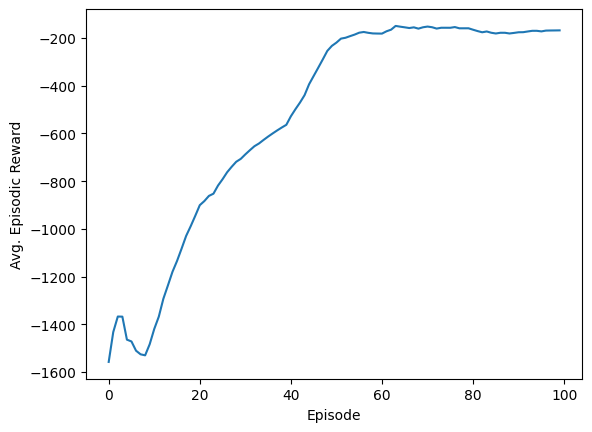

In [8]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, ou_noise)
        # Receive state and reward from environment.
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Another great environment to try this on is `LunarLander-v2` continuous, but it will take
more episodes to obtain good results.

In [9]:
# Save the weights
actor_model.save_weights("pendulum_actor.weights.h5")
critic_model.save_weights("pendulum_critic.weights.h5")

target_actor.save_weights("pendulum_target_actor.weights.h5")
target_critic.save_weights("pendulum_target_critic.weights.h5")

In [10]:
# Carrega os pesos do ator e crítico
actor_model.load_weights("pendulum_actor.weights.h5")
critic_model.load_weights("pendulum_critic.weights.h5")

target_actor.load_weights("pendulum_target_actor.weights.h5")
target_critic.load_weights("pendulum_target_critic.weights.h5")


In [12]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo, TimeLimit
import os
from IPython.display import Video
import keras

# Ambiente com steps maiores
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = TimeLimit(env, max_episode_steps=1000)
env = RecordVideo(env, video_folder="videos_pendulum", name_prefix="ddpg_pendulum_long")

# Executa um episódio
state, _ = env.reset()
done, truncated = False, False

while not (done or truncated):
    tf_state = keras.ops.expand_dims(keras.ops.convert_to_tensor(state), 0)
    action = actor_model(tf_state).numpy().flatten()
    state, reward, done, truncated, info = env.step(action)

env.close()

print('After 200 episodes:')
# Mostra o vídeo
video_path = [os.path.join("videos_pendulum", f) for f in os.listdir("videos_pendulum") if f.endswith(".mp4")][0]
Video(video_path, embed=True)


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos_pendulum folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


After 200 episodes:


Before Training:

![before_img](https://i.imgur.com/ox6b9rC.gif)